## Figure 9
### Preparation
Change the `res_path` variable to the path of simulator results. 

In [15]:
res_path = '../../../simulator/example_sim_results/'
ref_path = '../../jetson_stats' # GPU result derived from Jetson Orin Nano platform

Read simulation results from `main_dense.csv`, `main_adaptiv.csv`, `main_cmc.csv`, and `main_focus.csv`. For Edge GPU results, we directly read from `jetson_stats/figure9_gpu.csv`, which is measured on jetson orin nano platform.

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats

data_files = {
    'Systolic Array': res_path + '/main_dense.csv',
    'Adaptiv': res_path + '/main_adaptiv.csv',
    'CMC': res_path + '/main_cmc.csv',
    'Ours': res_path + '/main_focus.csv'
}
model_mapping = {'llava_vid': 'Llava-Vid', 'llava_onevision': 'Llava-OV', 'minicpm_v': 'MiniCPM'}
dataset_mapping = {'videomme': 'VideoMME', 'mlvu': 'MLVU', 'mvbench': 'MVBench'}
dfs = {}
for name, path in data_files.items():
    df = pd.read_csv(path)
    df = df[df['model'].isin(model_mapping.keys()) & df['dataset'].isin(dataset_mapping.keys())]
    df['model_name'] = df['model'].map(model_mapping)
    df['dataset_name'] = df['dataset'].map(dataset_mapping)
    dfs[name] = df

df_gpu = pd.read_csv(f'{ref_path}/figure9_gpu.csv')
gpu_model_mapping = model_mapping.copy()
gpu_model_mapping['minicpm_v'] = 'MiniCPM'

for method in ['GPU', 'GPU+FF']:
    df_method = df_gpu[df_gpu['Method'] == method].copy()
    df_method.rename(columns={'Model': 'model', 'Dataset': 'dataset'}, inplace=True)
    df_method = df_method[df_method['model'].isin(list(model_mapping.keys()) + ['minicpm_v'])]
    df_method = df_method[df_method['dataset'].isin(dataset_mapping.keys())]
    df_method['model_name'] = df_method['model'].map(gpu_model_mapping)
    df_method['dataset_name'] = df_method['dataset'].map(dataset_mapping)
    dfs[method] = df_method

models = ['Llava-Vid', 'Llava-OV', 'MiniCPM']
datasets = ['VideoMME', 'MLVU', 'MVBench']
methods = ['Systolic Array', 'GPU', 'Adaptiv', 'CMC', 'GPU+FF', 'Ours']

x_labels = []
for model in models:
    for dataset in datasets:
        x_labels.append(f'{dataset}\n{model}')
x_labels.append('Geometric\nMean')

baseline_time = []
for model in models:
    for dataset in datasets:
        match = dfs['Systolic Array'][
            (dfs['Systolic Array']['model_name'] == model) & 
            (dfs['Systolic Array']['dataset_name'] == dataset)
        ]
        if not match.empty:
            baseline_time.append(match.iloc[0]['execution_time'])

speedup_data = {method: [] for method in methods}
energy_data = {method: {'dram': [], 'sram': [], 'core': []} for method in methods}

for method in methods:
    for i, (model, dataset) in enumerate([(m, d) for m in models for d in datasets]):
        match = dfs[method][
            (dfs[method]['model_name'] == model) & 
            (dfs[method]['dataset_name'] == dataset)
        ]
        if not match.empty:
            speedup = baseline_time[i] / match.iloc[0]['execution_time']
            speedup_data[method].append(speedup)
            
            energy_data[method]['dram'].append(match.iloc[0]['dram_energy'])
            energy_data[method]['sram'].append(match.iloc[0]['sram_energy'])
            energy_data[method]['core'].append(match.iloc[0]['core_energy'])
        else:
            speedup_data[method].append(0)
            energy_data[method]['dram'].append(0)
            energy_data[method]['sram'].append(0)
            energy_data[method]['core'].append(0)
    
    speedup_geomean = stats.gmean([s for s in speedup_data[method] if s > 0])
    speedup_data[method].append(speedup_geomean)

    energy_data[method]['core'].append(np.mean(energy_data[method]['core']))
    energy_data[method]['sram'].append(np.mean(energy_data[method]['sram']))
    energy_data[method]['dram'].append(np.mean(energy_data[method]['dram']))

print("Data preparation completed!")

Data preparation completed!


### (a) Speedup

Plot speedup on various models and datasets normalized by dense systolic array accelerator


Speedup of Focus over each baseline (Geomean):
--------------------------------------------------
Focus vs Systolic Array : 4.466x
Focus vs GPU            : 7.896x
Focus vs Adaptiv        : 2.602x
Focus vs CMC            : 2.350x
Focus vs GPU+FF         : 2.370x
--------------------------------------------------


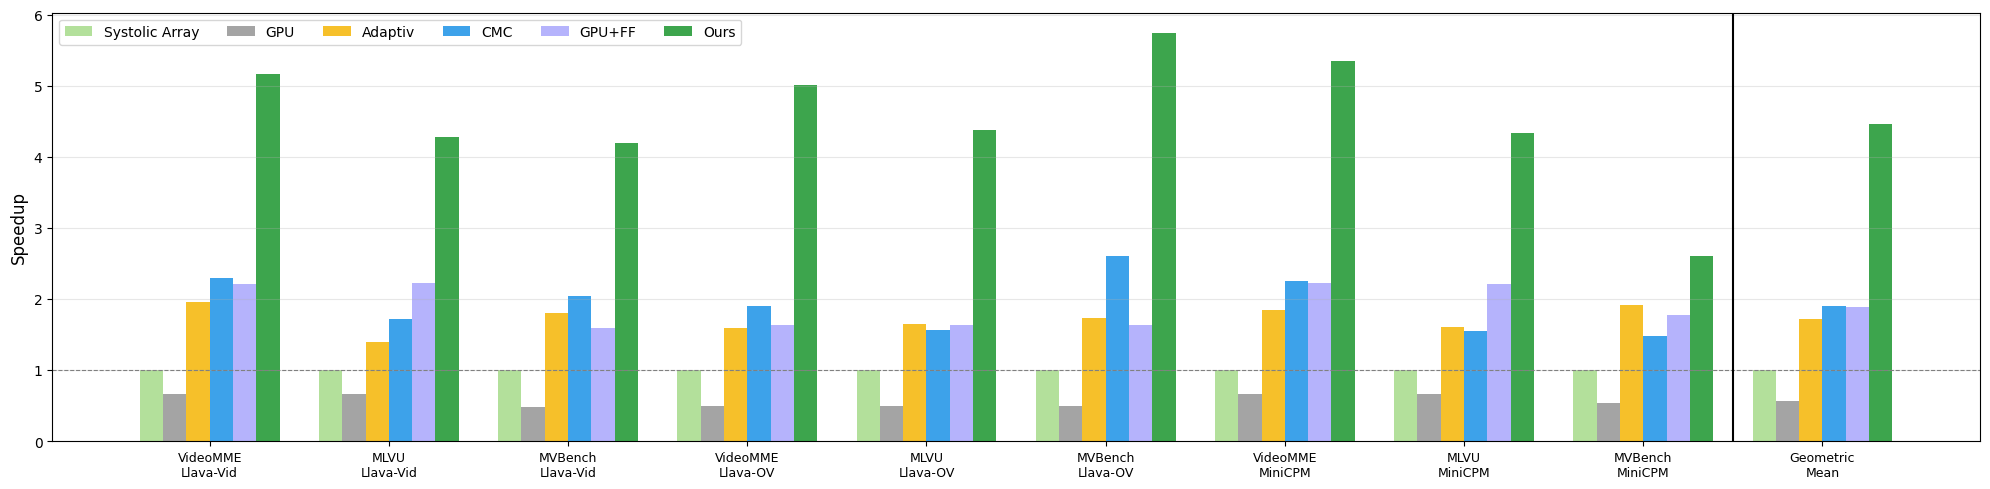

In [9]:
# Speedup
fig, ax = plt.subplots(figsize=(20, 5))

x = np.arange(len(x_labels))
width = 0.13
colors = ['#b3e09b', '#a4a4a4', '#f6c02a', '#3da2ea', '#b5b3fc', '#3da54d']

for i, method in enumerate(methods):
    offset = (i - 2.5) * width
    ax.bar(x + offset, speedup_data[method], width, label=method, color=colors[i])

ax.set_ylabel('Speedup', fontsize=12)
ax.set_xticks(x)
ax.set_xticklabels(x_labels, rotation=0, ha='center', fontsize=9)
ax.legend(loc='upper left', ncol=6)
ax.grid(axis='y', alpha=0.3)
ax.axhline(y=1.0, color='gray', linestyle='--', linewidth=0.8)
ax.axvline(x=8.5, color='black', linestyle='-', linewidth=1.5)

focus_geomean = speedup_data['Ours'][-1]  # Last element is geomean
baselines = ['Systolic Array', 'GPU', 'Adaptiv', 'CMC', 'GPU+FF']
print("\nSpeedup of Focus over each baseline (Geomean):")
print("-" * 50)
for baseline in baselines:
    baseline_geomean = speedup_data[baseline][-1]  # Last element is geomean
    if baseline_geomean > 0:
        speedup_over_baseline = focus_geomean / baseline_geomean
        print(f"Focus vs {baseline:15s}: {speedup_over_baseline:.3f}x")
    else:
        print(f"Focus vs {baseline:15s}: N/A (no data)")
print("-" * 50)

plt.tight_layout()
plt.show()

### (b) Energy

Plot the energy breakdown (core, buffer, and DRAM energy) of Focus and baselines on various datasets.


Energy Efficiency Gain of Focus over each baseline (Geomean):
------------------------------------------------------------
Focus vs Systolic Array : 4.669x
Focus vs GPU            : 17.115x
Focus vs Adaptiv        : 2.977x
Focus vs CMC            : 3.292x
Focus vs GPU+FF         : 5.134x
------------------------------------------------------------


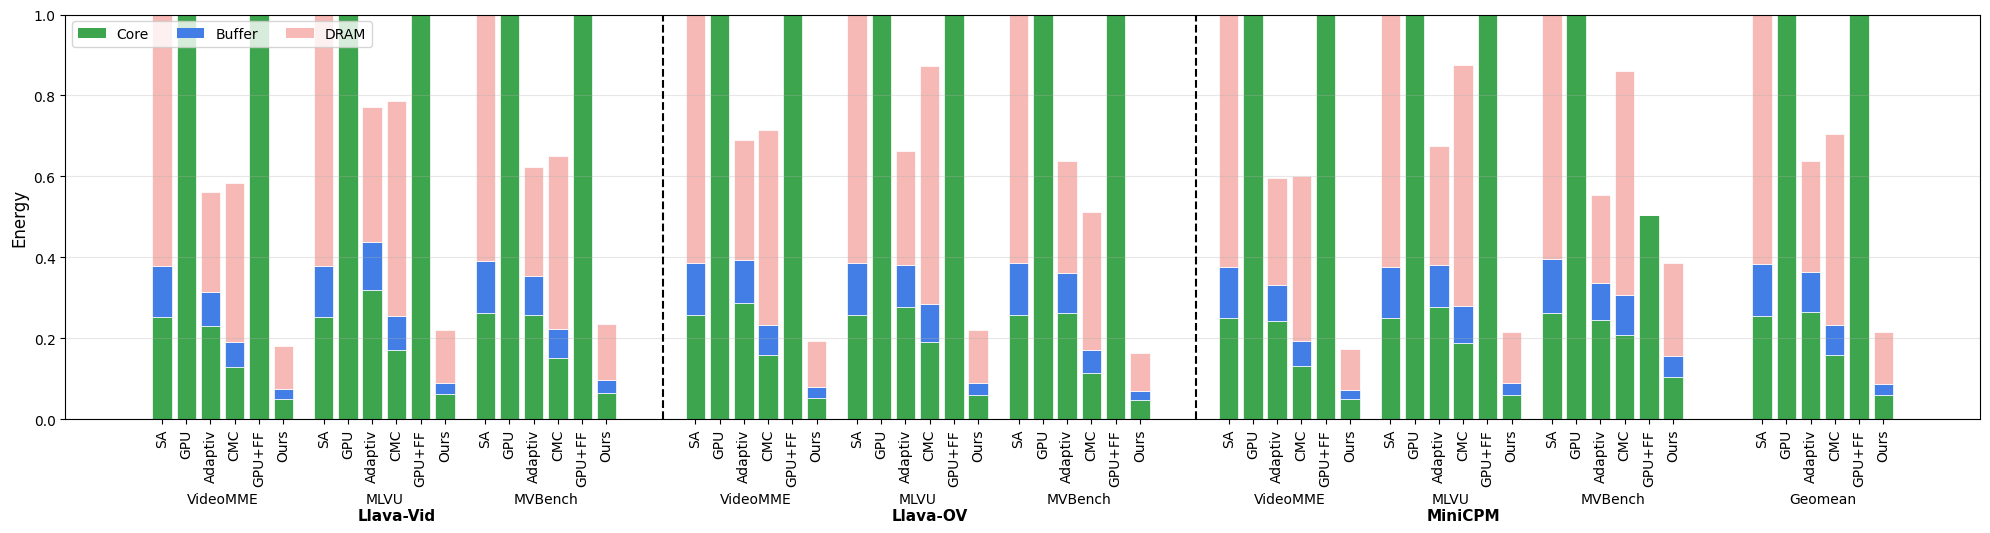

In [14]:
# Energy Breakdown
fig, ax = plt.subplots(figsize=(20, 5))
colors = ['#3da54d', '#427ee6', '#f6b9b6']
models = ['Llava-Vid', 'Llava-OV', 'MiniCPM']
datasets = ['VideoMME', 'MLVU', 'MVBench']

normalized_energy_data = {method: {'core': [], 'sram': [], 'dram': []} for method in methods}
for model in models:
    for dataset in datasets:
        baseline_idx = None
        for idx, label in enumerate(x_labels[:-1]):
            if model in label and dataset in label:
                baseline_idx = idx
                break
        
        if baseline_idx is not None:
            baseline_total = (energy_data['Systolic Array']['core'][baseline_idx] + 
                            energy_data['Systolic Array']['sram'][baseline_idx] + 
                            energy_data['Systolic Array']['dram'][baseline_idx])
            
            for method in methods:
                if baseline_total > 0:
                    normalized_energy_data[method]['core'].append(
                        energy_data[method]['core'][baseline_idx] / baseline_total)
                    normalized_energy_data[method]['sram'].append(
                        energy_data[method]['sram'][baseline_idx] / baseline_total)
                    normalized_energy_data[method]['dram'].append(
                        energy_data[method]['dram'][baseline_idx] / baseline_total)
                else:
                    normalized_energy_data[method]['core'].append(0)
                    normalized_energy_data[method]['sram'].append(0)
                    normalized_energy_data[method]['dram'].append(0)

# geomean
geomean_normalized = {method: {'core': [], 'sram': [], 'dram': []} for method in methods}
for method in methods:
    total_energies = []
    for i in range(len(normalized_energy_data[method]['core'])):
        total = (normalized_energy_data[method]['core'][i] + 
                normalized_energy_data[method]['sram'][i] + 
                normalized_energy_data[method]['dram'][i])
        total_energies.append(total)
    
    geomean_total = stats.gmean([e for e in total_energies if e > 0])
    avg_core_ratio = np.mean([normalized_energy_data[method]['core'][i] / total_energies[i] 
                               if total_energies[i] > 0 else 0 
                               for i in range(len(total_energies))])
    avg_sram_ratio = np.mean([normalized_energy_data[method]['sram'][i] / total_energies[i] 
                               if total_energies[i] > 0 else 0 
                               for i in range(len(total_energies))])
    avg_dram_ratio = np.mean([normalized_energy_data[method]['dram'][i] / total_energies[i] 
                               if total_energies[i] > 0 else 0 
                               for i in range(len(total_energies))])
    
    geomean_normalized[method]['core'] = geomean_total * avg_core_ratio
    geomean_normalized[method]['sram'] = geomean_total * avg_sram_ratio
    geomean_normalized[method]['dram'] = geomean_total * avg_dram_ratio


bar_width = 0.12
intra_group_spacing = 0.03
dataset_spacing = 0.1
model_spacing = 0.3

x_positions = []
x_ticks_methods = []
x_ticks_datasets = []
x_ticks_models = []

current_pos = 0
data_idx = 0

for model_idx, model in enumerate(models):
    model_start = current_pos
    for dataset_idx, dataset in enumerate(datasets):
        dataset_start = current_pos
        for method_idx, method in enumerate(methods):
            x_positions.append(current_pos)
            x_ticks_methods.append(method.replace('Systolic Array', 'SA'))
            current_pos += bar_width + intra_group_spacing
            data_idx += 1
        
        dataset_center = (dataset_start + current_pos - intra_group_spacing - bar_width) / 2
        x_ticks_datasets.append((dataset_center, dataset))
        current_pos += dataset_spacing
    
    model_center = (model_start + current_pos - dataset_spacing) / 2
    x_ticks_models.append((model_center, model))
    
    if model_idx < len(models) - 1:
        current_pos += model_spacing

# add geomean
current_pos += model_spacing
geomean_start = current_pos
for method_idx, method in enumerate(methods):
    x_positions.append(current_pos)
    x_ticks_methods.append(method.replace('Systolic Array', 'SA'))
    current_pos += bar_width + intra_group_spacing

geomean_center = (geomean_start + current_pos - intra_group_spacing - bar_width) / 2
x_ticks_datasets.append((geomean_center, 'Geomean'))
x_ticks_models.append((geomean_center, ''))

# draw bars
data_idx = 0
for model in models:
    for dataset in datasets:
        for method in methods:
            idx = data_idx // len(methods)
            ax.bar(x_positions[data_idx], normalized_energy_data[method]['core'][idx], 
                   bar_width, color=colors[0], edgecolor='white', linewidth=0.5)
            ax.bar(x_positions[data_idx], normalized_energy_data[method]['sram'][idx], 
                   bar_width, bottom=normalized_energy_data[method]['core'][idx],
                   color=colors[1], edgecolor='white', linewidth=0.5)
            ax.bar(x_positions[data_idx], normalized_energy_data[method]['dram'][idx], 
                   bar_width, 
                   bottom=normalized_energy_data[method]['core'][idx] + 
                          normalized_energy_data[method]['sram'][idx],
                   color=colors[2], edgecolor='white', linewidth=0.5)
            data_idx += 1

geomean_idx = len(models) * len(datasets) * len(methods)
for method_idx, method in enumerate(methods):
    ax.bar(x_positions[geomean_idx + method_idx], geomean_normalized[method]['core'], 
           bar_width, color=colors[0], edgecolor='white', linewidth=0.5)
    ax.bar(x_positions[geomean_idx + method_idx], geomean_normalized[method]['sram'], 
           bar_width, bottom=geomean_normalized[method]['core'],
           color=colors[1], edgecolor='white', linewidth=0.5)
    ax.bar(x_positions[geomean_idx + method_idx], geomean_normalized[method]['dram'], 
           bar_width, 
           bottom=geomean_normalized[method]['core'] + geomean_normalized[method]['sram'],
           color=colors[2], edgecolor='white', linewidth=0.5)

ax.set_xticks(x_positions)
ax.set_xticklabels(x_ticks_methods, fontsize=10, rotation=90, ha='center')
for pos, label in x_ticks_datasets:
    ax.text(pos, -0.18, label, ha='center', va='top', fontsize=10, transform=ax.get_xaxis_transform())
for pos, label in x_ticks_models:
    if label:
        ax.text(pos, -0.22, label, ha='center', va='top', fontsize=11, fontweight='bold',
                transform=ax.get_xaxis_transform())

# add vline
for model_idx in range(len(models)-1):
    divider_pos = x_ticks_models[model_idx][0] + (x_ticks_models[model_idx + 1][0] - x_ticks_models[model_idx][0]) / 2
    ax.axvline(x=divider_pos, color='black', linestyle='--', linewidth=1.5)

from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor=colors[0], label='Core'),
    Patch(facecolor=colors[1], label='Buffer'),
    Patch(facecolor=colors[2], label='DRAM')
]

ax.set_ylabel('Energy', fontsize=12)
ax.legend(handles=legend_elements, loc='upper left', ncol=3)
ax.grid(axis='y', alpha=0.3)
ax.set_ylim(0, 1)

# Print energy efficiency gain of Focus over each baseline using geomean data
focus_energy_total = (geomean_normalized['Ours']['core'] + 
                     geomean_normalized['Ours']['sram'] + 
                     geomean_normalized['Ours']['dram'])
focus_energy_efficiency = 1 / focus_energy_total

baselines = ['Systolic Array', 'GPU', 'Adaptiv', 'CMC', 'GPU+FF']
print("\nEnergy Efficiency Gain of Focus over each baseline (Geomean):")
print("-" * 60)
for baseline in baselines:
    baseline_energy_total = (geomean_normalized[baseline]['core'] + 
                            geomean_normalized[baseline]['sram'] + 
                            geomean_normalized[baseline]['dram'])
    if baseline_energy_total > 0:
        baseline_energy_efficiency = 1 / baseline_energy_total
        energy_efficiency_gain = focus_energy_efficiency / baseline_energy_efficiency
        print(f"Focus vs {baseline:15s}: {energy_efficiency_gain:.3f}x")
    else:
        print(f"Focus vs {baseline:15s}: N/A (no data)")
print("-" * 60)

plt.tight_layout()
plt.subplots_adjust(bottom=0.15)
plt.show()

### (c) Focus Detailed Area and Power Breakdown

Read the area and power breakdown of Focus from csv and plot in pie chart.

In [19]:
df_breakdown = pd.read_csv(f'{res_path}/detailed_power_area_breakdown.csv')
categories = {
    'Systolic Array': ['Systolic Array'],
    'DRAM': ['dram'],
    'Buffer': ['input', 'wgt', 'concentrate_out', 'output', 'layouter', 'similarity_map', 'similarity_table'],
    'SFU': ['FP16 Exp (SFU)', 'FP16 Sqrt (SFU)', 'FP16 Reciprocal (SFU)', 'FP16 Mul (SFU)', 'FP16 Add (SFU)'],
    'SEC': ['Max Unit (SEC)', 'Importance Vector Buffer (SEC)'],
    'SIC': ['Cosine Similarity (SIC)', 'L2 Norm (SIC)', 'Max Unit (SIC)', 'Average Update (SIC)', 'Accumulator (SIC)'],
}

area_data = {}
power_data = {}

for category, components in categories.items():
    area_sum = 0
    power_sum = 0
    for component in components:
        matching = df_breakdown[df_breakdown['component'] == component]
        if not matching.empty:
            area_sum += matching['area'].values[0]
            power_sum += matching['power'].values[0]
    area_data[category] = area_sum
    power_data[category] = power_sum

total_area = sum(area_data.values())
total_power = sum(power_data.values())

print(f"Total Area: {total_area:.2f} mm²")
print(f"Total Power: {total_power:.2f} mW")
print("\nArea Breakdown:")
for cat, val in area_data.items():
    print(f"  {cat}: {val:.2f} mm² ({val/total_area*100:.1f}%)")
print("\nPower Breakdown:")
for cat, val in power_data.items():
    print(f"  {cat}: {val:.2f} W ({val/total_power*100:.1f}%)")

Total Area: 3.21 mm²
Total Power: 1786.31 mW

Area Breakdown:
  Systolic Array: 1.41 mm² (44.0%)
  DRAM: 0.00 mm² (0.0%)
  Buffer: 1.38 mm² (43.2%)
  SFU: 0.32 mm² (10.1%)
  SEC: 0.06 mm² (1.9%)
  SIC: 0.03 mm² (0.8%)

Power Breakdown:
  Systolic Array: 324.37 W (18.2%)
  DRAM: 1049.94 W (58.8%)
  Buffer: 240.20 W (13.4%)
  SFU: 155.90 W (8.7%)
  SEC: 6.20 W (0.3%)
  SIC: 9.69 W (0.5%)


### (c)-1 Area Pie Chart

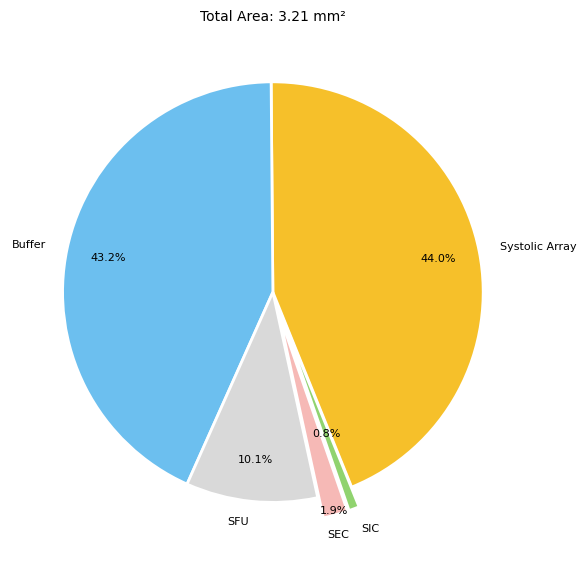

In [20]:
fig, ax = plt.subplots(figsize=(6, 6))
# SA, buffer, SFU, SIC, SEC, Dram
colors = ['#f6c02a', '#6cbfef', '#D9D9D9', '#f6b9b6', '#90d36f', '#b5b3fc']

filtered_data = {k: v for k, v in area_data.items() if v > 0}
labels = list(filtered_data.keys())
sizes = list(filtered_data.values())
percentages = [s/total_area*100 for s in sizes]
explode = [0.1 if pct < 5 else 0 for pct in percentages]

wedges, texts, autotexts = ax.pie(sizes, labels=labels, autopct='%1.1f%%',
                                    colors=colors,
                                    explode=explode,
                                    startangle=-68,
                                    textprops={'fontsize': 8},
                                    wedgeprops={'edgecolor': 'white', 'linewidth': 2},
                                    pctdistance=0.8)

for i, (autotext, pct) in enumerate(zip(autotexts, percentages)):
    if pct < 5:
        pos = autotext.get_position()
        if i == len(labels) - 2:
            autotext.set_position((pos[0] * 1.2, pos[1] * 1.2)) # SEC
        else:
            autotext.set_position((pos[0] * 0.8, pos[1] * 0.8)) # SIC

for i, (text, pct) in enumerate(zip(texts, percentages)):
    if pct < 5:
        pos = text.get_position()
        if i == len(labels) - 2:
            text.set_position((pos[0] * 0.8, pos[1]))   # SEC
        # else:  # SIC  
        #     text.set_position((pos[0] * 1.2, pos[1] * 1.2))

ax.set_title(f'Total Area: {total_area:.2f} mm²', fontsize=10)
plt.tight_layout()
plt.show()

### (c)-2 Power Pie Chart

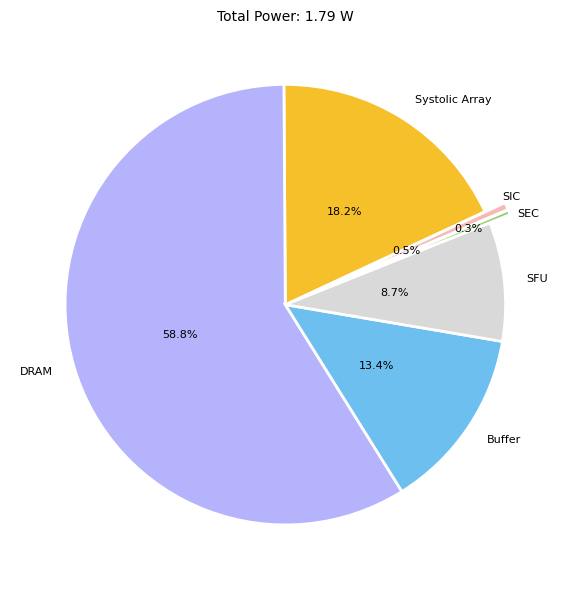

In [21]:
fig, ax = plt.subplots(figsize=(6, 6))
# SA, buffer, SFU, SIC, SEC, Dram
colors = ['#f6c02a', '#b5b3fc','#6cbfef', '#D9D9D9', '#90d36f', '#f6b9b6', ]

labels = list(power_data.keys())
sizes = list(power_data.values())
percentages = [s/total_power*100 for s in sizes]
explode = [0.1 if pct < 5 else 0 for pct in percentages]
wedges, texts, autotexts = ax.pie(sizes, labels=labels, autopct='%1.1f%%',
                                    colors=colors,
                                    explode=explode,
                                    startangle=25,
                                    textprops={'fontsize': 8},
                                    wedgeprops={'edgecolor': 'white', 'linewidth': 2},
                                    pctdistance=0.5)

for i, (autotext, pct) in enumerate(zip(autotexts, percentages)):
    if pct < 5:
        pos = autotext.get_position()
        if i == len(labels) - 2:
            autotext.set_position((pos[0] * 1.5, pos[1] * 1.5))     # SEC
        # else:
        #     autotext.set_position((pos[0] * 0.9, pos[1] * 0.9))   # SIC

for i, (text, pct) in enumerate(zip(texts, percentages)):
    if pct < 5:
        pos = text.get_position()
        if i == len(labels) - 2:  
            text.set_position((pos[0]*0.95, pos[1]*0.9))    # SEC
        else:  
            text.set_position((pos[0] * 0.9, pos[1]))       # SIC  

ax.set_title(f'Total Power: {total_power/1000:.2f} W', fontsize=10)
plt.tight_layout()
plt.show()